# Notebook 06: Phase 3 - Tối ưu hóa với K-Means Clustering

**Mục tiêu:**
- Sử dụng K-Means để phân nhóm các quốc gia dựa trên hồ sơ kinh tế/năng lượng.
- **Chiến lược**: "Chia để trị" (Divide & Conquer). Huấn luyện các mô hình chuyên biệt cho từng cụm.
- **Mô hình**: Linear Regression (Panel) VÀ XGBoost (Panel).
- **Đánh giá**: So sánh Mô hình Toàn cầu (Global Model) vs Mô hình cụ thể theo cụm (Cluster-specific Models).

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

import sys
import os

# Thêm src vào đường dẫn hệ thống
sys.path.append(os.path.abspath(os.path.join('../src')))
from preprocessing import load_data

SPLIT_YEAR = 2015
TARGET = 'Value_co2_emissions_kt_by_country'

# Tải dữ liệu
df_common = load_data('../data/processed/common_preprocessed.csv')
df_lr = load_data('../data/processed/lr_final_prep.csv')
df_xgb = load_data('../data/processed/xgb_final_prep.csv')

# Đồng bộ chỉ mục (index) cho LR
common_idx_lr = df_common.index.intersection(df_lr.index)
df_lr = df_lr.loc[common_idx_lr]

# Đồng bộ chỉ mục (index) cho XGB
common_idx_xgb = df_common.index.intersection(df_xgb.index)
df_xgb = df_xgb.loc[common_idx_xgb]

# Khôi phục cột Year nếu thiếu (Quan trọng để chia tập dữ liệu)
if 'Year' not in df_lr.columns:
    df_lr['Year'] = df_common.loc[df_lr.index, 'Year']
if 'Year' not in df_xgb.columns:
    df_xgb['Year'] = df_common.loc[df_xgb.index, 'Year']

Loaded data from ../data/processed/common_preprocessed.csv: (3473, 24)
Loaded data from ../data/processed/lr_final_prep.csv: (3260, 196)
Loaded data from ../data/processed/xgb_final_prep.csv: (3473, 24)


## 1. Phân tích Phân cụm (Clustering Analysis)
Chúng ta sẽ phân nhóm các quốc gia dựa trên đặc điểm *trung bình* theo thời gian (Mức độ phát triển).
**QUAN TRỌNG:** Để tránh rò rỉ dữ liệu (Data Leakage), chúng ta phải tính toán các hồ sơ này **CHỈ sử dụng Dữ liệu Huấn luyện** (< 2015).

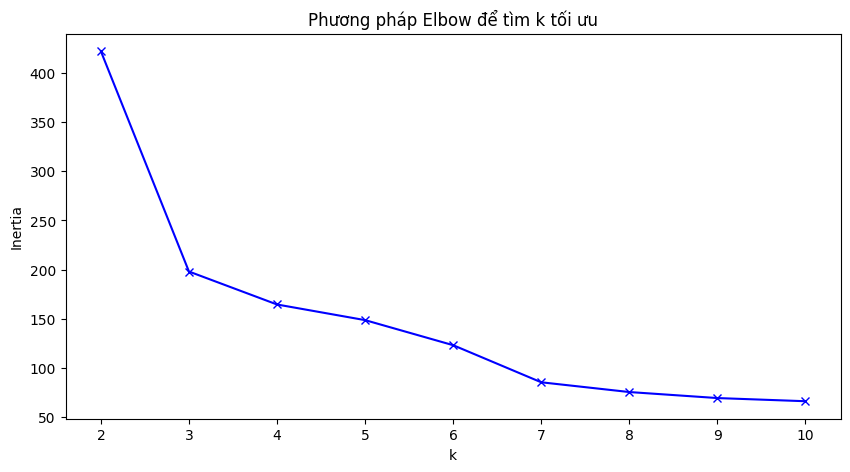

In [7]:
# Chọn các đặc trưng đại diện chính xác cho hồ sơ của một quốc gia
cluster_cols = [
    'gdp_per_capita',
    'Access to electricity (% of population)',
    'Renewable energy share in the total final energy consumption (%)',
    'Primary energy consumption per capita (kWh/person)'
]

# Tổng hợp theo Quốc gia (Trung bình) - CHỈ DÙNG DỮ LIỆU TRAIN (< SPLIT_YEAR)
df_profile = df_common[df_common['Year'] < SPLIT_YEAR].groupby('Entity')[cluster_cols].mean().dropna()

# Chuẩn hóa dữ liệu cho K-Means
scaler_cluster = StandardScaler()
X_cluster = scaler_cluster.fit_transform(df_profile)

# Phương pháp Elbow để tìm K tối ưu (Triển khai thủ công)
inertias = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_cluster)
    inertias.append(km.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(K_range, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Phương pháp Elbow để tìm k tối ưu')
plt.show()

In [8]:
# Áp dụng K-Means (Dùng K=3 cho đơn giản: Kém phát triển, Đang phát triển, Phát triển)
best_k = 3 
kmeans = KMeans(n_clusters=best_k, random_state=42)
df_profile['Cluster'] = kmeans.fit_predict(X_cluster)

# Kiểm tra các cụm
print("Tâm các cụm (Đã chuẩn hóa):")
print(df_profile.groupby('Cluster').mean())

# Ánh xạ Cluster ngược lại vào dữ liệu chính
cluster_map = df_profile['Cluster']
df_common['Cluster'] = df_common['Entity'].map(cluster_map)

# Gán Cluster cho dữ liệu LR và XGB
# Vì đã đồng bộ index, có thể ánh xạ qua df_common['Cluster']
# Cách an toàn: Ánh xạ theo Index
df_lr['Cluster'] = df_common.loc[df_lr.index, 'Cluster']
df_xgb['Cluster'] = df_common.loc[df_xgb.index, 'Cluster']

# Loại bỏ các dòng có Cluster là NaN (Các quốc gia bị loại khi tạo hồ sơ do thiếu dữ liệu)
df_lr.dropna(subset=['Cluster'], inplace=True)
df_xgb.dropna(subset=['Cluster'], inplace=True)

print(f"Dữ liệu LR cuối cùng với Clusters: {df_lr.shape}")
print(f"Dữ liệu XGB cuối cùng với Clusters: {df_xgb.shape}")

Tâm các cụm (Đã chuẩn hóa):
         gdp_per_capita  Access to electricity (% of population)  \
Cluster                                                            
0           6970.978968                                93.574427   
1          43721.355893                                99.952873   
2           1481.460603                                32.899115   

         Renewable energy share in the total final energy consumption (%)  \
Cluster                                                                     
0                                                18.952500                  
1                                                12.491875                  
2                                                70.594132                  

         Primary energy consumption per capita (kWh/person)  
Cluster                                                      
0                                             19188.018054   
1                                             81933.454513 

## 2. Huấn luyện & Đánh giá Mô hình
Chúng ta so sánh Mô hình Toàn cầu (Global) vs Mô hình Cục bộ (Local) cho cả LR và XGBoost.

In [9]:
# Khởi tạo danh sách kết quả
results = []

def eval_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return r2, rmse

def prepare_data(df, year_col='Year'):
    # Đảm bảo cột Year tồn tại để chia dữ liệu
    if year_col not in df.columns:
        print("Lỗi: Thiếu cột Year!")
        return None, None, None, None, 0
        
    train = df[df[year_col] < SPLIT_YEAR]
    test = df[df[year_col] >= SPLIT_YEAR]
    
    if len(train) == 0 or len(test) == 0:
        return None, None, None, None, 0
        
    drop_cols = [TARGET, year_col, 'Cluster']
    drop_cols = [c for c in drop_cols if c in df.columns]
    
    X_train = train.drop(columns=drop_cols)
    y_train = train[TARGET]
    X_test = test.drop(columns=drop_cols)
    y_test = test[TARGET]
    
    return X_train, y_train, X_test, y_test, len(test)

# ============================
# 1. Linear Regression (Panel)
# ============================
print("\n=== Linear Regression (Panel) ===")

# LR Toàn cầu
X_tr, y_tr, X_te, y_te, n = prepare_data(df_lr)
if n > 0:
    r2, rmse = eval_model(Ridge(alpha=1.0), X_tr, y_tr, X_te, y_te)
    r2_global_lr = r2
    print(f"LR Toàn cầu: R2 = {r2:.4f}")

# LR theo Cụm
weighted_r2_lr = 0
total_n_lr = 0

for c in sorted(df_lr['Cluster'].unique()):
    data_c = df_lr[df_lr['Cluster'] == c].copy()
    X_tr, y_tr, X_te, y_te, n = prepare_data(data_c)
    
    if n > 0:
        r2, rmse = eval_model(Ridge(alpha=1.0), X_tr, y_tr, X_te, y_te)
        weighted_r2_lr += r2 * n
        total_n_lr += n
        print(f"LR Cụm {int(c)}: R2 = {r2:.4f}, RMSE = {rmse:.2f}")
        results.append({
            'Algorithm': 'Linear Regression (Panel)',
            'Cluster': c,
            'R2': r2,
            'RMSE': rmse,
            'Samples': n
        })

if total_n_lr > 0:
    avg_r2_lr = weighted_r2_lr / total_n_lr
    results.append({
        'Algorithm': 'Linear Regression (Panel)',
        'Cluster': 'Weighted_Avg',
        'R2': avg_r2_lr,
        'RMSE': np.nan,
        'Samples': total_n_lr
    })
    print(f"LR Trung bình trọng số: {avg_r2_lr:.4f}")

# ============================
# 2. XGBoost (Panel)
# ============================
print("\n=== XGBoost (Panel) ===")

# XGB Toàn cầu
X_tr, y_tr, X_te, y_te, n = prepare_data(df_xgb)
if n > 0:
    r2, rmse = eval_model(XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1), X_tr, y_tr, X_te, y_te)
    r2_global_xgb = r2
    print(f"XGB Toàn cầu: R2 = {r2:.4f}")

# XGB theo Cụm
weighted_r2_xgb = 0
total_n_xgb = 0

for c in sorted(df_xgb['Cluster'].unique()):
    data_c = df_xgb[df_xgb['Cluster'] == c].copy()
    X_tr, y_tr, X_te, y_te, n = prepare_data(data_c)
    
    if n > 0:
        r2, rmse = eval_model(XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1), X_tr, y_tr, X_te, y_te)
        weighted_r2_xgb += r2 * n
        total_n_xgb += n
        print(f"XGB Cụm {int(c)}: R2 = {r2:.4f}, RMSE = {rmse:.2f}")
        results.append({
            'Algorithm': 'XGBoost (Panel)',
            'Cluster': c,
            'R2': r2,
            'RMSE': rmse,
            'Samples': n
        })

if total_n_xgb > 0:
    avg_r2_xgb = weighted_r2_xgb / total_n_xgb
    results.append({
        'Algorithm': 'XGBoost (Panel)',
        'Cluster': 'Weighted_Avg',
        'R2': avg_r2_xgb,
        'RMSE': np.nan,
        'Samples': total_n_xgb
    })
    print(f"XGB Trung bình trọng số: {avg_r2_xgb:.4f}")


=== Linear Regression (Panel) ===
LR Toàn cầu: R2 = 0.9989
LR Cụm 0: R2 = 0.9957, RMSE = 77357.02
LR Cụm 1: R2 = 0.8450, RMSE = 42190.83
LR Cụm 2: R2 = 0.9930, RMSE = 12442.06
LR Trung bình trọng số: 0.9683

=== XGBoost (Panel) ===
XGB Toàn cầu: R2 = 0.7440
XGB Cụm 0: R2 = 0.8016, RMSE = 440774.89
XGB Cụm 1: R2 = 0.7716, RMSE = 379256.46
XGB Cụm 2: R2 = 0.7816, RMSE = 8047.64
XGB Trung bình trọng số: 0.7903


In [10]:
# Lưu kết quả
summary_df = pd.DataFrame(results)
summary_df.to_csv('../data/results/phase3_kmeans_results.csv', index=False)
print("\nĐã lưu kết quả tối ưu hóa vào phase3_kmeans_results.csv")


Đã lưu kết quả tối ưu hóa vào phase3_kmeans_results.csv
